## Building Fake News Classifer with DistilBERT, T5

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Link to dataset: https://www.kaggle.com/datasets/sonalgarg174/ifnd-dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IFND.csv',encoding = "ISO-8859-1")
df

,id,Statement,Image,Web,Category,Date,Label
0,2,"WHO praises India's Aarogya Setu app, says it ...",https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,COVID-19,Oct-20,TRUE
1,3,"In Delhi, Deputy US Secretary of State Stephen...",https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,VIOLENCE,Oct-20,TRUE
2,4,LAC tensions: China's strategy behind delibera...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,TERROR,Oct-20,TRUE
3,5,India has signed 250 documents on Space cooper...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,COVID-19,Oct-20,TRUE
4,6,Tamil Nadu chief minister's mother passes away...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,ELECTION,Oct-20,TRUE
...,...,...,...,...,...,...,...
56709,56711,Fact Check: This is not Bruce Lee playing ping...,https://akm-img-a-in.tosshub.com/indiatoday/im...,INDIATODAY,MISLEADING,11-2019,Fake
56710,56712,Fact Check: Did Japan construct this bridge in...,https://akm-img-a-in.tosshub.com/indiatoday/im...,INDIATODAY,COVID-19,10-2019,Fake
56711,56713,Fact Check: Viral video of Mexico earthquake i...,https://akm-img-a-in.tosshub.com/indiatoday/im...,INDIATODAY,MISLEADING,10-2019,Fake
56712,56714,Fact Check: Ballet performance by Chinese coup...,https://akm-img-a-in.tosshub.com/indiatoday/im...,INDIATODAY,COVID-19,9-2019,Fake


***EDA***

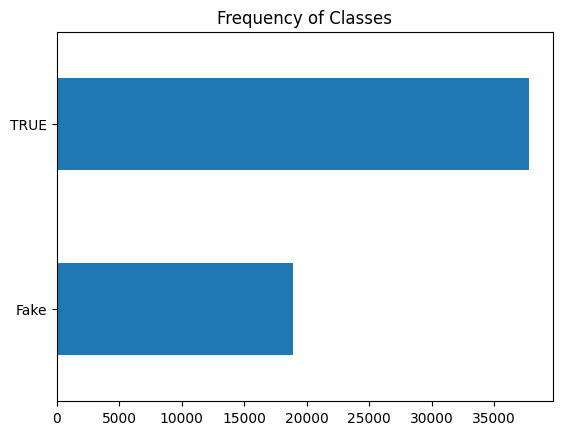

In [ ]:
df["Label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

**Observation:** Imbalanced dataset <br>
**Potential problem:** Bias for majority class and worse accuracy for minority class <br>
**Solution:** Use class weights while training model

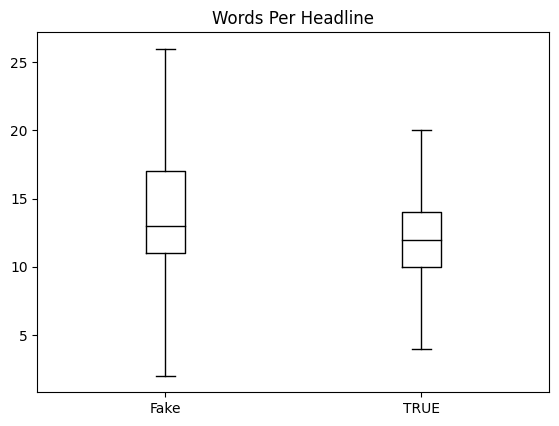

In [ ]:
df["Words Per Headline"] = df["Statement"].str.split().apply(len)
df.boxplot("Words Per Headline", by="Label", grid=False,
 showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

Range of word length for real news - (10,14) <br>
Range of word length for fake news - (11,17) <br>
**Ovservation:** Fake news headlines tend to be more inconsistent with the title length.

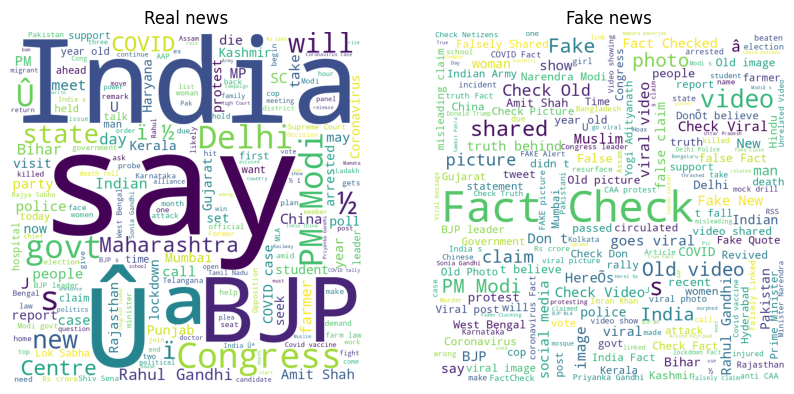

In [ ]:
from wordcloud import WordCloud

wordcloud_positive = WordCloud(width=800, height=800, background_color='white').generate(" ".join(df[df['Label'] == 'TRUE']['Statement']))
wordcloud_negative = WordCloud(width=800, height=800, background_color='white').generate(" ".join(df[df['Label'] == 'Fake']['Statement']))

# plot word clouds
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(wordcloud_positive)
axes[0].set_title('Real news')
axes[0].axis('off')
axes[1].imshow(wordcloud_negative)
axes[1].set_title('Fake news')
axes[1].axis('off')
plt.show()

**Observation:** We can see from the **word cloud** that for many fake news headlines there is a common prefix **"Fact Check"** attached to it and the original headline also seems to be altered with **negative and skeptical words** like "not", "did", etc.<br>
**Potential problem:** Can introduce bias into the model <br>
**Solution:** Remove extra and unneccesary words

### Pre-processing

Dropping unnecessary columns as we will only focus on the text in this case

In [ ]:
df = df.drop(['Image','Web','Date','Category','id'],axis=1)

In [ ]:
df = df.rename(columns={'Label': 'label_name'})

***Adding binary row for labels***

In [ ]:
y = pd.get_dummies(df['label_name'])
y = y.iloc[:,0].values
df['label']=y

In [ ]:
df

,Statement,label_name,Words Per Headline,label
0,"WHO praises India's Aarogya Setu app, says it ...",TRUE,13,0
1,"In Delhi, Deputy US Secretary of State Stephen...",TRUE,13,0
2,LAC tensions: China's strategy behind delibera...,TRUE,10,0
3,India has signed 250 documents on Space cooper...,TRUE,13,0
4,Tamil Nadu chief minister's mother passes away...,TRUE,9,0
...,...,...,...,...
56709,Fact Check: This is not Bruce Lee playing ping...,Fake,11,1
56710,Fact Check: Did Japan construct this bridge in...,Fake,10,1
56711,Fact Check: Viral video of Mexico earthquake i...,Fake,11,1
56712,Fact Check: Ballet performance by Chinese coup...,Fake,12,1


In [ ]:
df.label_name.value_counts()

TRUE    37800
Fake    18914
Name: label_name, dtype: int64

In [ ]:
count = df['Statement'].str.count('Fact Check')
count.sum()

9362

In [ ]:
from collections import Counter

# filter DataFrame by category of interest
df_filtered = df[df['label'] == 1]

# join all text in the filtered DataFrame
text_joined = ' '.join(df_filtered['Statement'])

# split the joined text into words
words = text_joined.split()

# count the occurrence of each word
word_counts = Counter(words)

# get the most common words
word_counts.most_common(25)

[('Check:', 8620),
 ('Fact', 8050),
 ('of', 6295),
 ('in', 5016),
 ('not', 3577),
 ('the', 3516),
 ('is', 3457),
 ('to', 3180),
 ('a', 2942),
 ('video', 2312),
 ('Of', 2169),
 ('as', 2137),
 ('No,', 2119),
 ('this', 2067),
 ('Did', 1936),
 ('from', 1929),
 ('on', 1922),
 ('Video', 1799),
 ('for', 1573),
 ('In', 1487),
 ('viral', 1474),
 ('with', 1473),
 ('This', 1427),
 ('Old', 1399),
 ('To', 1256)]

In [ ]:
words_removed = ['Fact Check','truth behind','fact checked','Falsely','False','FAKE','not','don t','Alert','FactCheck','misleading','never','wrong','unrelated','old','no','did',',',':']

In [ ]:
#Removing prefixes and negative words
pattern = r'\b(?:{})\b'.format('|'.join(map(re.escape, words_removed)))
df.loc[df['label']==1, 'Statement'] = df.loc[df['label']==1, 'Statement'].apply(lambda x: re.sub(pattern, '', x, flags=re.IGNORECASE))
#Trimming the remaining headline
df['Statement'] = df['Statement'].str.replace(r'^[^a-zA-Z]*', '')

<ipython-input-8-046db68acd1b>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Statement'] = df['Statement'].str.replace(r'^[^a-zA-Z]*', '')


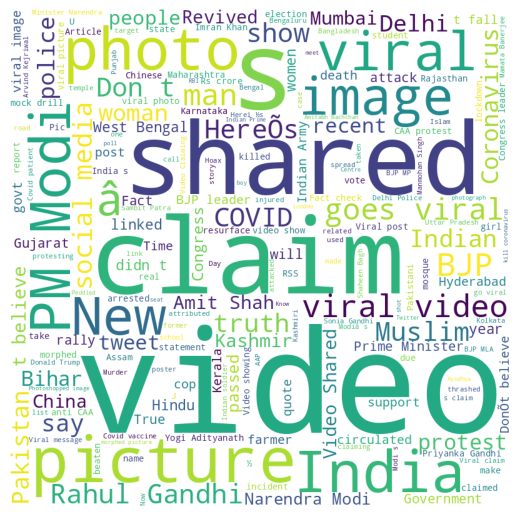

In [ ]:
#Updated word cloud of fake news
wordcloud_negative = WordCloud(width=800, height=800, background_color='white').generate(" ".join(df[df['label'] == 1]['Statement']))

plt.figure(figsize=(5,5))
plt.imshow(wordcloud_negative)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [ ]:
from collections import Counter

# filter DataFrame by category of interest
df_filtered = df[df['label'] == 1]

# join all text in the filtered DataFrame
text_joined = ' '.join(df_filtered['Statement'])

# split the joined text into words
words = text_joined.split()

# count the occurrence of each word
word_counts = Counter(words)

# get the most common words
word_counts.most_common(25)

[('of', 6295),
 ('in', 5016),
 ('the', 3516),
 ('is', 3457),
 ('to', 3180),
 ('a', 2942),
 ('video', 2312),
 ('Of', 2169),
 ('as', 2137),
 ('this', 2067),
 ('from', 1929),
 ('on', 1922),
 ('Video', 1799),
 ('for', 1573),
 ('In', 1487),
 ('viral', 1474),
 ('with', 1473),
 ('This', 1429),
 ('To', 1256),
 ('Is', 1219),
 ('PM', 1218),
 ('Viral', 1196),
 ('Modi', 1153),
 ('Indian', 1128),
 ('A', 1103)]

In [ ]:
df[df['label'] == 1]

,Statement,label_name,Words Per Headline,label
37800,video of BKS Iyengar shared as PM Modi perform...,Fake,13,1
37801,Conspiracy theory claims Sushant was killed fo...,Fake,13,1
37802,Gujarats Rani ki Vav shared as palace built b...,Fake,15,1
37803,PM Modi has announced another Covid-19 lockdown,Fake,11,1
37804,The curious case of a 'desecrated' Kali idol i...,Fake,14,1
...,...,...,...,...
56709,This is Bruce Lee playing ping-pong with Nunc...,Fake,11,1
56710,Japan construct this bridge in 24 hours?,Fake,10,1
56711,Viral video of Mexico earthquake is 2 years,Fake,11,1
56712,Ballet performance by Chinese couple goes vira...,Fake,12,1


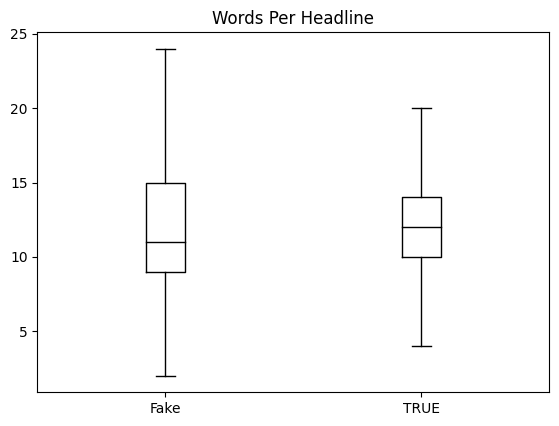

In [ ]:
df["Words Per Headline"] = df["Statement"].str.split().apply(len)
df.boxplot("Words Per Headline", by="label_name", grid=False,
 showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

### Pre-processing using Hugging Face Dataset

In [ ]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 16.8 MB/s eta 0:00:00


In [ ]:
from datasets import Dataset

In [ ]:
#Converting dataframe into Hugging face dataset object
dataset = Dataset.from_pandas(df)

In [ ]:
dataset

Dataset({
    features: ['Statement', 'label_name', 'Words Per Headline', 'label'],
    num_rows: 56714
})

In [ ]:
dataset.features

{'Statement': Value(dtype='string', id=None),
 'label_name': Value(dtype='string', id=None),
 'Words Per Headline': Value(dtype='int64', id=None),
 'label': Value(dtype='uint8', id=None)}

In [ ]:
#Shuffling the dataset so that fake and real news are present at random
dataset = dataset.shuffle()

In [ ]:
train_test_split = dataset.train_test_split(test_size=0.20)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

# Further split the train dataset into train and validation
train_val_split = train_dataset.train_test_split(test_size=0.25)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

In [ ]:
from datasets import DatasetDict

dataset_dict = DatasetDict({"train": train_dataset, "validation": val_dataset, "test": test_dataset})

In [ ]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['Statement', 'label_name', 'Words Per Headline', 'label'],
        num_rows: 34028
    })
    validation: Dataset({
        features: ['Statement', 'label_name', 'Words Per Headline', 'label'],
        num_rows: 11343
    })
    test: Dataset({
        features: ['Statement', 'label_name', 'Words Per Headline', 'label'],
        num_rows: 11343
    })
})

In [ ]:
trainds = dataset_dict["train"]

### Using DistilBERT Tokenizer

In [ ]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
def tokenize(batch):
 return tokenizer(batch["Statement"], padding=True, truncation=True)

In [ ]:
print(tokenize(dataset_dict["train"][:2]))

{'input_ids': [[101, 8040, 8908, 17393, 1997, 11948, 12848, 12338, 10102, 20462, 2005, 2966, 4638, 2039, 102, 0, 0, 0, 0, 0, 0, 0], [101, 2634, 2891, 2522, 17258, 19552, 2627, 6070, 1011, 2474, 10023, 2928, 1010, 7233, 3446, 2012, 6109, 1012, 5641, 2566, 9358, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
dataset_encoded = dataset_dict.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/34028 [00:00<?, ? examples/s]

Map:   0%|          | 0/11343 [00:00<?, ? examples/s]

Map:   0%|          | 0/11343 [00:00<?, ? examples/s]

In [ ]:
print(dataset_encoded["train"].column_names)

['Statement', 'label_name', 'Words Per Headline', 'label', 'input_ids', 'attention_mask']


In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Fine-tuning model

In [ ]:
!nvidia-smi

Tue Apr 11 03:08:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#load a pre-trained model checkpoint and set number of labels to 2 for binary classification
from transformers import AutoModelForSequenceClassification
num_labels = 2
model = (AutoModelForSequenceClassification
 .from_pretrained(model_ckpt, num_labels=num_labels)
 .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

In [ ]:
#to calculate the accuracy and F1-score of the model predictions at every epoch
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
 labels = pred.label_ids
 preds = pred.predictions.argmax(-1)
 f1 = f1_score(labels, preds, average="weighted")
 acc = accuracy_score(labels, preds)
 return {"accuracy": acc, "f1": f1}

In [ ]:
#since we have an imbalanced dataset we use class weights to balance the output
class_weights = torch.tensor([1.0, 2.0])  # class 0 has weight 1.0, class 1 has weight 2.0

In [ ]:
from transformers import Trainer, TrainingArguments
batch_size = 32     # number of training examples that will be processed in each training step, higher batch sizes lead to faster trainig but can also give suboptimal solutions
# the loss function with class weights
loss_fn = torch.nn.BCELoss(weight=class_weights)
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs= 3,
                                  learning_rate= 2e-5,
                                  per_device_train_batch_size= batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.015,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["validation"],
                  tokenizer=tokenizer)

trainer.train();

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.011500,0.316797,0.960328,0.960140
2,0.009600,0.297955,0.959535,0.959459
3,0.011000,0.279028,0.961298,0.961174


In [ ]:
trainer2 = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["validation"],
                  tokenizer=tokenizer)

trainer2.train();

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.077100,0.183319,0.962796,0.962599
2,0.043400,0.207049,0.962620,0.962500


***Visualising outputs***

In [ ]:
#Takes in true and predicted labels and prints confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
 cm = confusion_matrix(y_true, y_preds, normalize="true")
 fig, ax = plt.subplots(figsize=(6, 6))
 disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
 disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
 plt.title("Normalized confusion matrix")
 plt.show()

In [ ]:
#use the fine-tuned model to predit the outputs of the validation data
preds_output = trainer.predict(dataset_encoded["validation"])
preds_output.metrics

{'test_loss': 0.27902787923812866,
 'test_accuracy': 0.9612977166534427,
 'test_f1': 0.9611739893137446,
 'test_runtime': 23.0164,
 'test_samples_per_second': 492.823,
 'test_steps_per_second': 15.424}

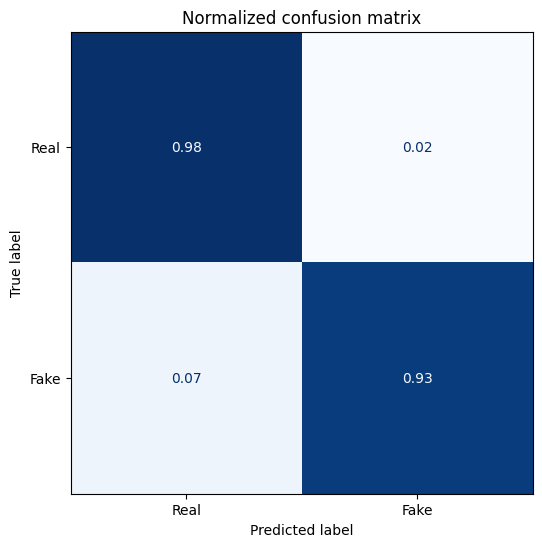

In [ ]:
#plot confusion matrix using the true labels and the predicted labels
y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(dataset_dict["validation"]["label"])
plot_confusion_matrix(y_preds, y_valid, ['Real','Fake'])

***Error Analysis***

In [ ]:
from torch.nn.functional import cross_entropy

In [ ]:
#When we pass the label during the forward pass, the loss is automatically calculated
and returned
def forward_pass_with_label(batch):
 # Place all input tensors on the same device as the model
 inputs = {k:v.to(device) for k,v in batch.items()
           if k in tokenizer.model_input_names}
 with torch.no_grad():
   output = model(**inputs)
   pred_label = torch.argmax(output.logits, axis=-1)
   loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")
 # Place outputs on CPU for compatibility with other dataset columns
 return {"loss": loss.cpu().numpy(),
         "predicted_label": pred_label.cpu().numpy()}

In [ ]:
# Convert our dataset back to PyTorch tensors
dataset_encoded.set_format("torch",
 columns=["input_ids", "attention_mask", "label"])
# Compute loss values
dataset_encoded["validation"] = dataset_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/11343 [00:00<?, ? examples/s]

In [ ]:
def label_int2str(row):
  if row == 0:
    return "TRUE"
  else:
    return "Fake"

In [ ]:
#Finally, we create a DataFrame with the texts, losses, and predicted/true labels:
dataset_encoded.set_format("pandas")
cols = ["Statement", "label_name", "predicted_label", "loss"]
df_test = dataset_encoded["validation"][:][cols]
df_test["predicted_label"] = (df_test["predicted_label"]
 .apply(label_int2str))
df_test

,Statement,label_name,predicted_label,loss
0,Image Of Three IPS Officers Sitting Together V...,Fake,Fake,0.000018
1,"Police Case Filed Against Rahul Gandhi, Priyan...",TRUE,TRUE,0.000016
2,Liquor worth Rs 70 lakh seized in Û÷dryÛª Bihar,TRUE,TRUE,0.000006
3,PM Modi to receive UAEï¿½s highest civilian aw...,TRUE,TRUE,0.000011
4,Grave of India-Pakistan war hero Brigadier Usm...,TRUE,TRUE,0.000020
...,...,...,...,...
11338,Drunk cop beaten for alleged misbehavior with ...,Fake,Fake,0.000033
11339,"TMC holds talks with Rajib Banerjee, expels Su...",TRUE,TRUE,0.000009
11340,"Ahead of Bihar elections, BJP leader Usha Vidy...",TRUE,TRUE,0.000403
11341,BJP veterans LK Advani and Murli Manohar Joshi...,TRUE,TRUE,0.000039


In [ ]:
#data samples with the highest losses
df_test.sort_values("loss", ascending=False).head(10)

,Statement,label_name,predicted_label,loss
8006,KashmirÕs COVID figures show integration compl...,Fake,TRUE,11.856919
8365,US assures India of fair solution for Tri-Vall...,Fake,TRUE,11.852841
6779,Bombay High Court orders lower court to re-hea...,Fake,TRUE,11.720325
6819,Army Chief General MM Naravane begins 6-day vi...,Fake,TRUE,11.654277
3568,AG advise against appeal in Vodafone arbitrati...,Fake,TRUE,11.601564
336,SC slams Centre for going ahead with Central V...,Fake,TRUE,11.601161
251,Army Called In To Control Seven Areas In Mumbai,Fake,TRUE,11.598207
4664,"Kashmir: Surveillance, area domination ops int...",Fake,TRUE,11.552135
166,Rahul Gandhi holds virtual meet to discuss Con...,Fake,TRUE,11.534412
6973,"After nudge from Cong brass, Rajasthan leader ...",Fake,TRUE,11.526808


In [ ]:
# data samples with the smallest losses
df_test.sort_values("loss", ascending=True).head(10)

,Statement,label_name,predicted_label,loss
5031,"CanÛªt stop migrantsÛª movement, says SC",TRUE,TRUE,0.000005
4592,P Chidambaram takes dig at Nirmala over Û÷Act...,TRUE,TRUE,0.000005
1286,Kanpur encounter exposes Û÷encounter speciali...,TRUE,TRUE,0.000005
2387,HC stays transfers of ArmyÛªs first Û÷colone...,TRUE,TRUE,0.000005
4327,"LAC row: India to press for early, complete di...",TRUE,TRUE,0.000005
494,"IndiaÛªs Covid recovery rate nears 74 pc, onl...",TRUE,TRUE,0.000005
899,IndiaÛªs coronavirus tally crosses 45-lakh ma...,TRUE,TRUE,0.000005
4950,"DU final year exam for UG, PG from July 1; Û÷...",TRUE,TRUE,0.000005
7606,"GaggedÛª at judgeÛªs farewell, Bar chief fumes",TRUE,TRUE,0.000005
1109,UPSC: Former MP fuel pump stafferÛªs son achi...,TRUE,TRUE,0.000005


### Using SBert

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(['label_name','label'], axis=1)
y = df['label']

X = X.rename(columns={'Statement': 'text'})

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create new dataframes for training and testing sets
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)

In [ ]:
# Prepare data for training
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")
train_encodings = tokenizer(list(train_df["text"]), truncation=True, padding=True)
test_encodings = tokenizer(list(test_df["text"]), truncation=True, padding=True)
train_labels = torch.tensor(list(train_df["label"]))
test_labels = torch.tensor(list(test_df["label"]))

# Create TensorDataset and DataLoader for train and test sets
train_dataset = TensorDataset(torch.tensor(train_encodings["input_ids"]),  #it contains input_ids, attention_mask, and labels tensors for each training example., similar to data_encoded
                              torch.tensor(train_encodings["attention_mask"]),
                              train_labels)
test_dataset = TensorDataset(torch.tensor(test_encodings["input_ids"]),
                             torch.tensor(test_encodings["attention_mask"]),
                             test_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True,pin_memory=True, verbose=True) #responsible for loading the data from the train dataset in batches and shuffling the order of the batches during each epoch
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load pre-trained SBERT model
model = AutoModelForSequenceClassification.from_pretrained("sentence-transformers/bert-base-nli-mean-tokens")

# Define optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Define training function
def train(model, dataloader, optimizer, scheduler):
    model.train()
    for batch in dataloader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

# Define evaluation function
def evaluate(model, dataloader):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, axis=1).tolist())
            true_labels.extend(labels.tolist())
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predictions, average="weighted")
    return accuracy, precision, recall, f1_score

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/bert-base-nli-mean-tokens and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Train and evaluate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for epoch in range(epochs):
    train(model, train_dataloader, optimizer, scheduler)
    accuracy, precision, recall, f1_score = evaluate(model, test_dataloader)
    print(f"Epoch {epoch+1}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 score: {f1_score}")

Epoch 1:
Accuracy: 0.9620911575420964
Precision: 0.96199628823462
Recall: 0.9620911575420964
F1 score: 0.9620071785671994
Epoch 2:
Accuracy: 0.9671162831702371
Precision: 0.9671315816096606
Recall: 0.9671162831702371
F1 score: 0.9669591594192557
Epoch 3:
Accuracy: 0.9619148373446178
Precision: 0.9624095151209012
Recall: 0.9619148373446178
F1 score: 0.961552033804036
Epoch 4:
Accuracy: 0.9655294013929295
Precision: 0.9656131144343291
Recall: 0.9655294013929295
F1 score: 0.9653271880874561
Epoch 5:
Accuracy: 0.9649122807017544
Precision: 0.9648298403175434
Recall: 0.9649122807017544
F1 score: 0.964824900425065


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

# Evaluate the model on the test set
y_true = test_labels
y_pred = []

for i, batch in enumerate(test_dataloader):
    # Move inputs to device
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # Compute logits
    with torch.no_grad():
        logits = model(b_input_ids, attention_mask=b_input_mask)[0]

    # Apply softmax to compute probabilities
    probs = F.softmax(logits, dim=1)

    # Predict labels
    preds = torch.argmax(probs, dim=1)
    y_pred.extend(preds.cpu().numpy())

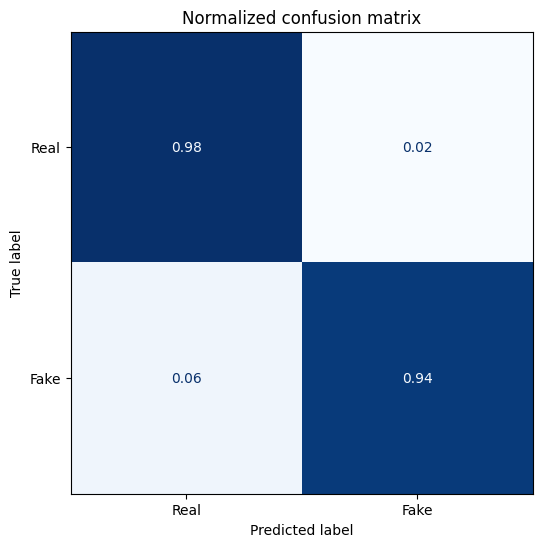

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize="true")
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real','Fake'])
disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
plt.title("Normalized confusion matrix")
plt.show()

### Using T5

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(['label_name','label'], axis=1)
y = df['label']

X = X.rename(columns={'Statement': 'text'})

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create new dataframes for training and testing sets
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)

train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

In [ ]:
train_df

,text,label
0,"Feel like Im being raped again & again, says ...",0
1,BJP men torture youth during lockdown? HereÕs ...,1
2,"For the first time, LPG sold more than petrol ...",0
3,Man forced to say on camera he is a child-kidn...,1
4,Why Edelweiss fund is still bullish on Indiaï¿...,0
...,...,...
45366,This picture is from Hizbul commander Zakir M...,1
45367,Viral photo of the flood is from Bihar but Au...,1
45368,Sushant Singh Rajput case: Û÷Uddhav never int...,0
45369,"migrants on way home die, 14 others injured in...",0


In [ ]:
# Load necessary libraries
import torch
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW
from sklearn.metrics import f1_score

# Define model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Define training parameters
batch_size = 8
epochs = 3
learning_rate = 5e-5

# Define optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Fine-tune the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(epochs):
    total_loss = 0

    # Train the model
    model.train()
    for i in range(0, len(train_df), batch_size):
        batch_df = train_df[i:i+batch_size]
        inputs = tokenizer(batch_df['text'].tolist(), padding=True, truncation=True, return_tensors='pt').to(device)
        labels = tokenizer(batch_df['label'].tolist(), padding=True, truncation=True, return_tensors='pt').to(device)

        outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], labels=labels['input_ids'])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        predicted_labels = []
        actual_labels = []
        for i in range(0, len(test_df), batch_size):
            batch_df = test_df[i:i+batch_size]
            inputs = tokenizer(batch_df['text'].tolist(), padding=True, truncation=True, return_tensors='pt').to(device)
            labels = tokenizer(batch_df['label'].tolist(), padding=True, truncation=True, return_tensors='pt').to(device)

            outputs = model.generate(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=2)
            predicted = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
            predicted_labels.extend(predicted)
            actual_labels.extend(batch_df['label'])

            for predicted, actual in zip(predicted, batch_df['label']):
                if predicted == actual:
                    correct += 1
                total += 1

        # Compute f1 score
        f1 = f1_score(actual_labels, predicted_labels, average='macro')

    # Print results
    train_loss = total_loss / (len(train_df) / batch_size)
    test_accuracy = correct / total
    print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Accuracy = {test_accuracy:.4f}, F1 Score = {f1:.4f}')


/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_depreca

Epoch 1: Train Loss = 0.1711, Test Accuracy = 0.2940, F1 Score = 0.3063
Epoch 2: Train Loss = 0.0487, Test Accuracy = 0.3056, F1 Score = 0.3131
Epoch 3: Train Loss = 0.0386, Test Accuracy = 0.3064, F1 Score = 0.3150
